In [1]:
import codecs
import pandas as pd
import nbimporter
import spacy
from textblob import TextBlob
from MySQL_connection import *
from preprocessing import *
from detect_es import *
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
from scipy import sparse
import pickle

Importing Jupyter notebook from MySQL_connection.ipynb
Importing Jupyter notebook from preprocessing.ipynb
Importing Jupyter notebook from RDFmanagement.ipynb
Importing Jupyter notebook from detect_es.ipynb


In [2]:
set_connectionMySQL()

In [3]:
#Recuperar archivos de datos
"""
titulos_asignaturas= stopwordsList("files/asignaturas.txt")
carreras_asignaturas= stopwordsList("files/carreras.txt")
resultados_asignaturas= stopwordsList("files/resultados.txt")
asignatura_titulacion= stopwordsList("files/asignatura_tit.txt")
"""
es_stopwords= stopwordsList("stopwords/spanish")
punt_stopwords= stopwordsList("stopwords/puntuacion")

lista_materias = []
titulos_asignaturas = ieee_select_query("SELECT o FROM planes WHERE p = 'asignatura'")
for asig in titulos_asignaturas:
    lista_materias.append(asig['o'])
    
print (lista_materias)

ranks = []
for i in range(0,len(lista_materias)):
    ranks.append(i)
    
#print (lista_materias)
    
#print (len(ranks))
#print (len(titulos_asignaturas))
#print (len(resultados_asignaturas))

['FÍSICA PARA LAS CIENCIAS BIOMÉDICAS', 'INTEGRADO DE CLÍNICA MEDICA: ONCOLOGÍA', 'INTEGRADO DE CLÍNICA III CARDIOVASCULAR', 'MORFOFUNCIONAL IV NEUROFISIOLOGÍA TEORÍA', 'MORFOFUNCIONAL II ANATOMÍA TEORÍA', 'MORFOFUNCIONAL II FISIOLOGÍA PRÁCTICA', 'MORFOFUNCIONAL I EMBRIOLOGÍA', 'MORFOFUNCIONAL I HISTOLOGÍA TEORÍA', 'MICROFINANZAS', 'ADMINISTRACIÓN I', 'ECONOMÍA DEL ECUADOR', 'MORFOFUNCIONAL III ANATOMÍA TEORÍA', 'MORFOFUNCIONAL III FISIOLOGÍA PRÁCTICA', 'CUIDADOS DE LA PERSONA ENFERMA', 'ADMINISTRACIÓN EN SALUD', 'EXTERNADO GP 3.3', 'BIOQUÍMICA', 'CONTABILIDAD GENERAL', 'MORFOFUNCIONAL II HISTOLOGÍA TEORÍA', 'FUNDAMENTOS FILOSÓFICOS DE LA MEDICINA', 'INTEGRADO DE CLÍNICAS QUIRÚRGICAS TRAUMATOLOGÍA', 'MORFOFUNCIONAL I ANATOMÍA TEORÍA', 'SEMIOTECNIA', 'TALLERES: RCP, SIGNOS VITALES, VENDAJES, INYECCIONES', 'MATEMÁTICAS PARA LAS CIENCIAS BIOMÉDICAS', 'FAMILIA Y VIDA GP1.1', 'INTEGRADO DE CLÍNICA I: FISIOPATOLOGÍA', 'INTEGRADO DE CLÍNICA QUIRÚRGICAS UROLOGÍA', 'BIOLOGÍA GENERAL', 'MORFOFUN

In [4]:
#Crear vocabularios
totalvocab_lemmatized = []
totalvocab_tokenized = []
for i in lista_materias:
    doc = es_parsing(i)
    allwords_lemmatized = lemmatizing(doc,punt_stopwords)
    totalvocab_lemmatized.extend(allwords_lemmatized)
    
    allwords_tokenized = tokenizing(doc,punt_stopwords)
    totalvocab_tokenized.extend(allwords_tokenized)

In [5]:
vocab_dataframe = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_lemmatized)

In [6]:
print ('there are ' + str(vocab_dataframe.shape[0]) + ' items in vocab_frame')

there are 4435 items in vocab_frame


In [7]:
tokenize = lambda doc: doc.lower().split(" ")

In [8]:
tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',max_df=0.9, stop_words=es_stopwords,
                                 use_idf=True, tokenizer=tokenize, analyzer='word', ngram_range=(1,3))

In [9]:
tfidf_matrix = tfidf_vectorizer.fit_transform(lista_materias)

In [10]:
#Guardar Matriz TF-IDF con PICKLE
with open("tfidfmaterias.pkl", 'wb') as handle:
    pickle.dump(tfidf_matrix, handle)
#load the content
tfidf = pickle.load(open("tfidfmaterias.pkl", "rb" ) ) 
print (tfidf)

  (0, 1053)	0.35000538284402766
  (0, 375)	0.3541733763440052
  (0, 289)	0.4251233887932129
  (0, 1055)	0.4251233887932129
  (0, 380)	0.4251233887932129
  (0, 1057)	0.4581132658767017
  (1, 1401)	0.2521234878198566
  (1, 433)	0.250195020410324
  (1, 1612)	0.34776943707836583
  (1, 1777)	0.3831880944977395
  (1, 1404)	0.2655298613331315
  (1, 448)	0.34776943707836583
  (1, 1615)	0.3831880944977395
  (1, 1409)	0.34776943707836583
  (1, 451)	0.3831880944977395
  (2, 1401)	0.2581999761437882
  (2, 433)	0.2562250302811831
  (2, 1404)	0.27192945986319306
  (2, 1306)	0.23698204613393528
  (2, 325)	0.39242340217263877
  (2, 440)	0.3712054721627859
  (2, 1310)	0.39242340217263877
  (2, 1407)	0.3712054721627859
  (2, 441)	0.39242340217263877
  (3, 1702)	0.24924523659723333
  :	:
  (1321, 0)	0.40768025446022677
  (1321, 906)	0.6274939724216644
  (1321, 907)	0.6633612324350319
  (1322, 1205)	0.5773502691896257
  (1322, 1889)	0.5773502691896257
  (1322, 1206)	0.5773502691896257
  (1323, 1030)	1.0
 

In [11]:
#Guardar Matriz TF-IDF con NPZ
sparse.save_npz("tfidf-materias.npz", tfidf_matrix)
tfidf_matrix1 = sparse.load_npz("tfidf-materias.npz")
#print (tfidf_matrix1)

In [12]:
terms = tfidf_vectorizer.get_feature_names()

In [13]:
#similaridad del coseno
dist = 1 - cosine_similarity(tfidf_matrix)
#print (dist)

# Guardar matriz de distancias
with open("distmaterias.pkl", 'wb') as handle:
    pickle.dump(dist, handle)
#load the content
#distancias = pickle.load(open("distmaterias.pkl", "rb" ) ) 
#print (tfidf)

In [14]:
#cluster jerárquico
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
print (linkage_matrix)

[[0.00000000e+00 7.04000000e+02 0.00000000e+00 2.00000000e+00]
 [3.00000000e+00 6.54000000e+02 0.00000000e+00 2.00000000e+00]
 [4.00000000e+00 6.98000000e+02 0.00000000e+00 2.00000000e+00]
 ...
 [2.64200000e+03 2.65100000e+03 2.56256848e+01 1.74000000e+02]
 [2.63900000e+03 2.65000000e+03 3.93113722e+01 1.15400000e+03]
 [2.65200000e+03 2.65300000e+03 7.13646594e+01 1.32800000e+03]]


/Users/ela/Documents/entornos/jupyterenv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


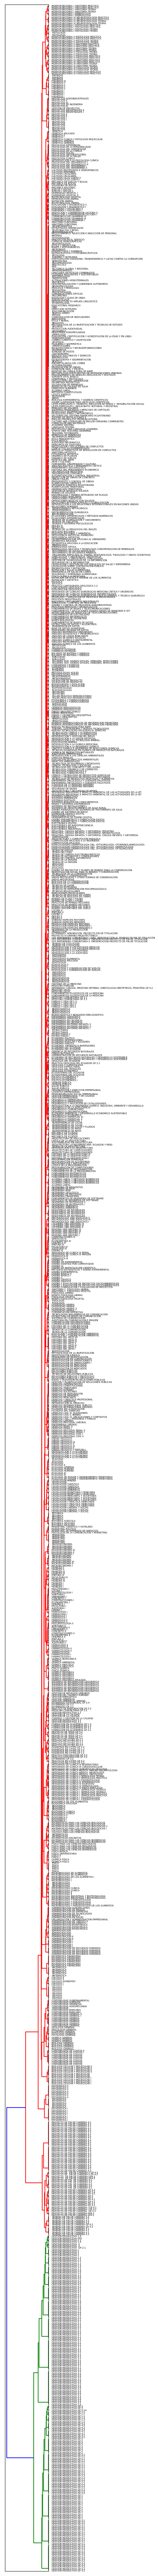

In [15]:
fig, ax = plt.subplots(figsize=(5,80)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=lista_materias);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    grid_linewidth=50)

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('clusters_allmaterias.png', dpi=200) #save figure as ward_clusters

In [16]:
plt.close()

In [17]:
close_connectionMySQL()